<a href="https://colab.research.google.com/github/MatiMajewski/Beginners/blob/main/Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
!pip install pandas openpyxl



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [110]:
import pandas as pd

In [111]:
import pandas as pd
from IPython.display import display
from pathlib import Path
import re
import csv

csv_name = "RYNE_3786_CREL_20251207150625.csv"
preferred_paths = [
    Path(csv_name),
    Path.cwd() / csv_name,
    Path.home() / "OneDrive" / "Desktop" / "Projekt analiza danych w r i phyton" / "Beginners" / csv_name,
    Path.home() / csv_name,
]

# Pick the first existing path; fallback to a home-wide search if needed.
data_path = next((p for p in preferred_paths if p.exists()), None)
if data_path is None:
    matches = list(Path.home().rglob(csv_name))
    if matches:
        data_path = matches[0]
    else:
        raise FileNotFoundError(f"Nie znaleziono pliku {csv_name}.")

print(f"Uzywam pliku: {data_path}")

dane = pd.read_csv(
    data_path,
    delimiter=";",
    encoding="utf-8",
    on_bad_lines="skip",
    quoting=csv.QUOTE_MINIMAL,
    quotechar='"',
)

# Normalizacja nazw kolumn i tekstow
dane.columns = dane.columns.str.strip().str.strip('"')
string_cols = [
    "Nazwa",
    "Transakcje rynkowe",
    "Powierzchnia użytkowa lokali mieszkalnych",
    "Jednostka miary",
    "Atrybut",
]
for col in string_cols:
    if col in dane.columns:
        dane[col] = dane[col].astype(str).str.strip().str.strip('"')

# Liczbowe kolumny
for num_col in ["Rok", "Wartosc"]:
    if num_col in dane.columns:
        dane[num_col] = (
            dane[num_col]
            .astype(str)
            .str.replace("\u00a0", "", regex=False)
            .str.replace(" ", "", regex=False)
            .str.strip()
            .str.strip('"')
        )
        dane[num_col] = pd.to_numeric(dane[num_col], errors="coerce")

# Format kod as 00-000, case-insensitive column match
kod_col = next((c for c in dane.columns if c.lower() == "kod"), None)
if kod_col:
    def format_kod(val):
        digits = re.sub(r"\D", "", str(val))
        if not digits:
            return pd.NA
        digits = digits[:5].zfill(5)
        return f"{digits[:2]}-{digits[2:]}"

    dane[kod_col] = dane[kod_col].apply(format_kod)

# Usuniecie niepotrzebnych kolumn
dane = dane.drop(columns=["Atrybut", "Unnamed: 8"], errors="ignore")

display(dane)


Uzywam pliku: RYNE_3786_CREL_20251207150625.csv


,Kod,Nazwa,Transakcje rynkowe,Powierzchnia użytkowa lokali mieszkalnych,Rok,Wartosc,Jednostka miary
0,00-000,POLSKA,rynek pierwotny,ogółem,2010,309936.00,zł
1,00-000,POLSKA,rynek pierwotny,ogółem,2011,314723.00,zł
2,00-000,POLSKA,rynek pierwotny,ogółem,2012,304789.00,zł
3,00-000,POLSKA,rynek pierwotny,ogółem,2013,300364.00,zł
4,00-000,POLSKA,rynek pierwotny,ogółem,2014,300784.00,zł
...,...,...,...,...,...,...,...
5950,32-630,Powiat m. Świnoujście,rynek pierwotny,ogółem,2020,413457.00,zł
5951,32-630,Powiat m. Świnoujście,rynek pierwotny,ogółem,2021,463104.00,zł
5952,32-630,Powiat m. Świnoujście,rynek pierwotny,ogółem,2022,514484.00,zł
5953,32-630,Powiat m. Świnoujście,rynek pierwotny,ogółem,2023,531975.00,zł


Wiersze POLSKA przed czyszczeniem: 15
    Rok   Wartosc
0  2010 309936.00
1  2011 314723.00
2  2012 304789.00
3  2013 300364.00
4  2014 300784.00
Po czyszczeniu wierszy: 15
    Rok  Wartosc
0  2010  3099360
1  2011  3147230
2  2012  3047890
3  2013  3003640
4  2014  3007840
    Rok  Wartosc  pct_vs_first
0  2010  3099360          0.00
1  2011  3147230          1.54
2  2012  3047890         -1.66
3  2013  3003640         -3.09
4  2014  3007840         -2.95


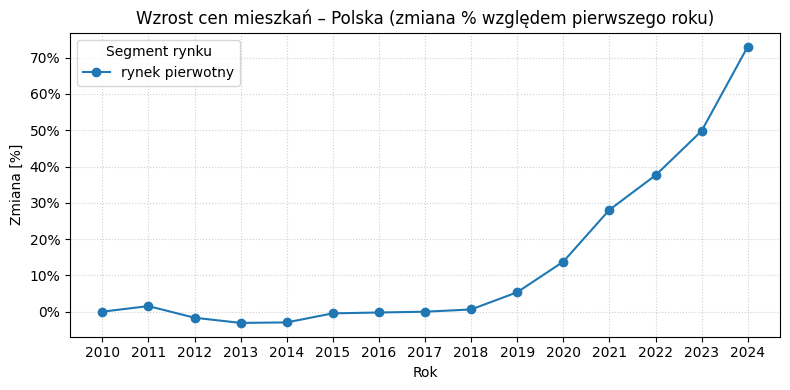

In [112]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re

# Filtr Polska
mask_polska = dane["Nazwa"].str.contains("POLSKA", case=False, na=False)
polska = dane[mask_polska].copy()
print("Wiersze POLSKA przed czyszczeniem:", len(polska))
print(polska[["Rok", "Wartosc"]].head())

# Agresywne czyszczenie
polska["Rok"] = polska["Rok"].astype(str).str.extract(r"(\d{4})")[0]
polska["Wartosc"] = polska["Wartosc"].astype(str).str.replace(r"[^0-9]", "", regex=True)
polska["Rok"] = pd.to_numeric(polska["Rok"], errors="coerce")
polska["Wartosc"] = pd.to_numeric(polska["Wartosc"], errors="coerce")
polska = polska.dropna(subset=["Rok", "Wartosc"]).sort_values("Rok")
print("Po czyszczeniu wierszy:", len(polska))
print(polska[["Rok", "Wartosc"]].head())

if polska.empty:
    raise ValueError("Brak liczbowych danych dla Polski po czyszczeniu.")

# Zmiana procentowa względem pierwszego roku w każdej serii
pct_list = []
for seg, df_seg in polska.groupby("Transakcje rynkowe"):
    base = df_seg.iloc[0]["Wartosc"]
    pct = df_seg.assign(pct_vs_first=(df_seg["Wartosc"] / base - 1) * 100)
    pct_list.append(pct)
polska_pct = pd.concat(pct_list)

print(polska_pct[["Rok", "Wartosc", "pct_vs_first"]].head())

fig, ax = plt.subplots(figsize=(8, 4))
for segment, df_seg in polska_pct.groupby("Transakcje rynkowe"):
    ax.plot(df_seg["Rok"], df_seg["pct_vs_first"], marker="o", label=segment)

ax.set_title("Wzrost cen mieszkań – Polska (zmiana % względem pierwszego roku)")
ax.set_xlabel("Rok")
ax.set_ylabel("Zmiana [%]")
ax.legend(title="Segment rynku")
ax.grid(True, linestyle=":", alpha=0.6)
ax.set_xticks(sorted(polska_pct["Rok"].unique()))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

plt.tight_layout()
plt.show()


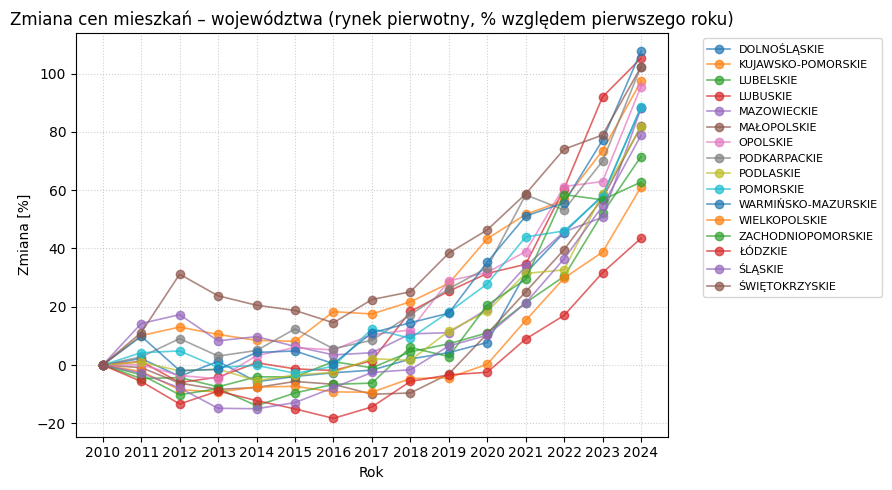

In [113]:
# Wykres: zmiana % względem pierwszego roku dla województw (rynek pierwotny)
import matplotlib.pyplot as plt

voiv = dane.copy()
voiv["Rok"] = pd.to_numeric(voiv["Rok"], errors="coerce")
voiv["Wartosc"] = pd.to_numeric(voiv["Wartosc"], errors="coerce")
voiv = voiv.dropna(subset=["Rok", "Wartosc"])
voiv = voiv[voiv["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]
voiv = voiv[~voiv["Nazwa"].str.contains("POLSKA|powiat|gmina", case=False, na=False)]

pct_rows = []
for name, df in voiv.groupby("Nazwa"):
    df = df.sort_values("Rok")
    base = df.iloc[0]["Wartosc"]
    pct_rows.append(df.assign(pct_vs_first=(df["Wartosc"] / base - 1) * 100))
voiv_pct = pd.concat(pct_rows, ignore_index=True)

fig, ax = plt.subplots(figsize=(9, 5))
for name, df in voiv_pct.groupby("Nazwa"):
    ax.plot(df["Rok"], df["pct_vs_first"], marker="o", linewidth=1.2, alpha=0.7, label=name)

ax.set_title("Zmiana cen mieszkań – województwa (rynek pierwotny, % względem pierwszego roku)")
ax.set_xlabel("Rok")
ax.set_ylabel("Zmiana [%]")
ax.grid(True, linestyle=":", alpha=0.6)
ax.set_xticks(sorted(voiv_pct["Rok"].unique()))
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


In [114]:
# Tabela: CAGR (Polska i województwa, rynek pierwotny)
import pandas as pd

scope = dane.copy()
scope["Rok"] = pd.to_numeric(scope["Rok"], errors="coerce")
scope["Wartosc"] = pd.to_numeric(scope["Wartosc"], errors="coerce")
scope = scope.dropna(subset=["Rok", "Wartosc"])
scope = scope[scope["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]

# Polska + województwa
scope = scope[(scope["Nazwa"].str.contains("POLSKA", case=False, na=False)) | (~scope["Nazwa"].str.contains("powiat|gmina", case=False, na=False))]

rows = []
for name, df in scope.groupby("Nazwa"):
    df = df.sort_values("Rok")
    first = df.iloc[0]["Wartosc"]
    last = df.iloc[-1]["Wartosc"]
    years = df.iloc[-1]["Rok"] - df.iloc[0]["Rok"]
    cagr = (last / first) ** (1 / years) - 1 if years > 0 else float("nan")
    rows.append({"Nazwa": name, "Rok_start": int(df.iloc[0]["Rok"]), "Rok_end": int(df.iloc[-1]["Rok"]), "CAGR": cagr, "Start": first, "Koniec": last})

tab_cagr = pd.DataFrame(rows).sort_values("CAGR", ascending=False)

# Ładny podgląd
pd.options.display.float_format = "{:.2f}".format
print(tab_cagr.head(5))
display(tab_cagr)


                  Nazwa  Rok_start  Rok_end  CAGR     Start    Koniec
11  WARMIŃSKO-MAZURSKIE       2010     2024  0.05 206177.00 428176.00
3              LUBUSKIE       2010     2024  0.05 177963.00 365272.00
7          PODKARPACKIE       2010     2024  0.05 207634.00 420127.00
16       ŚWIĘTOKRZYSKIE       2010     2024  0.05 205826.00 416320.00
1    KUJAWSKO-POMORSKIE       2010     2024  0.05 201776.00 398135.00


,Nazwa,Rok_start,Rok_end,CAGR,Start,Koniec
11,WARMIŃSKO-MAZURSKIE,2010,2024,0.05,206177.00,428176.00
3,LUBUSKIE,2010,2024,0.05,177963.00,365272.00
7,PODKARPACKIE,2010,2024,0.05,207634.00,420127.00
16,ŚWIĘTOKRZYSKIE,2010,2024,0.05,205826.00,416320.00
1,KUJAWSKO-POMORSKIE,2010,2024,0.05,201776.00,398135.00
6,OPOLSKIE,2010,2024,0.05,215586.00,421586.00
10,POMORSKIE,2010,2024,0.05,305608.00,576509.00
0,DOLNOŚLĄSKIE,2010,2024,0.05,312729.00,588538.00
4,MAZOWIECKIE,2010,2024,0.05,374545.00,704484.00
5,MAŁOPOLSKIE,2010,2024,0.04,359656.00,654439.00


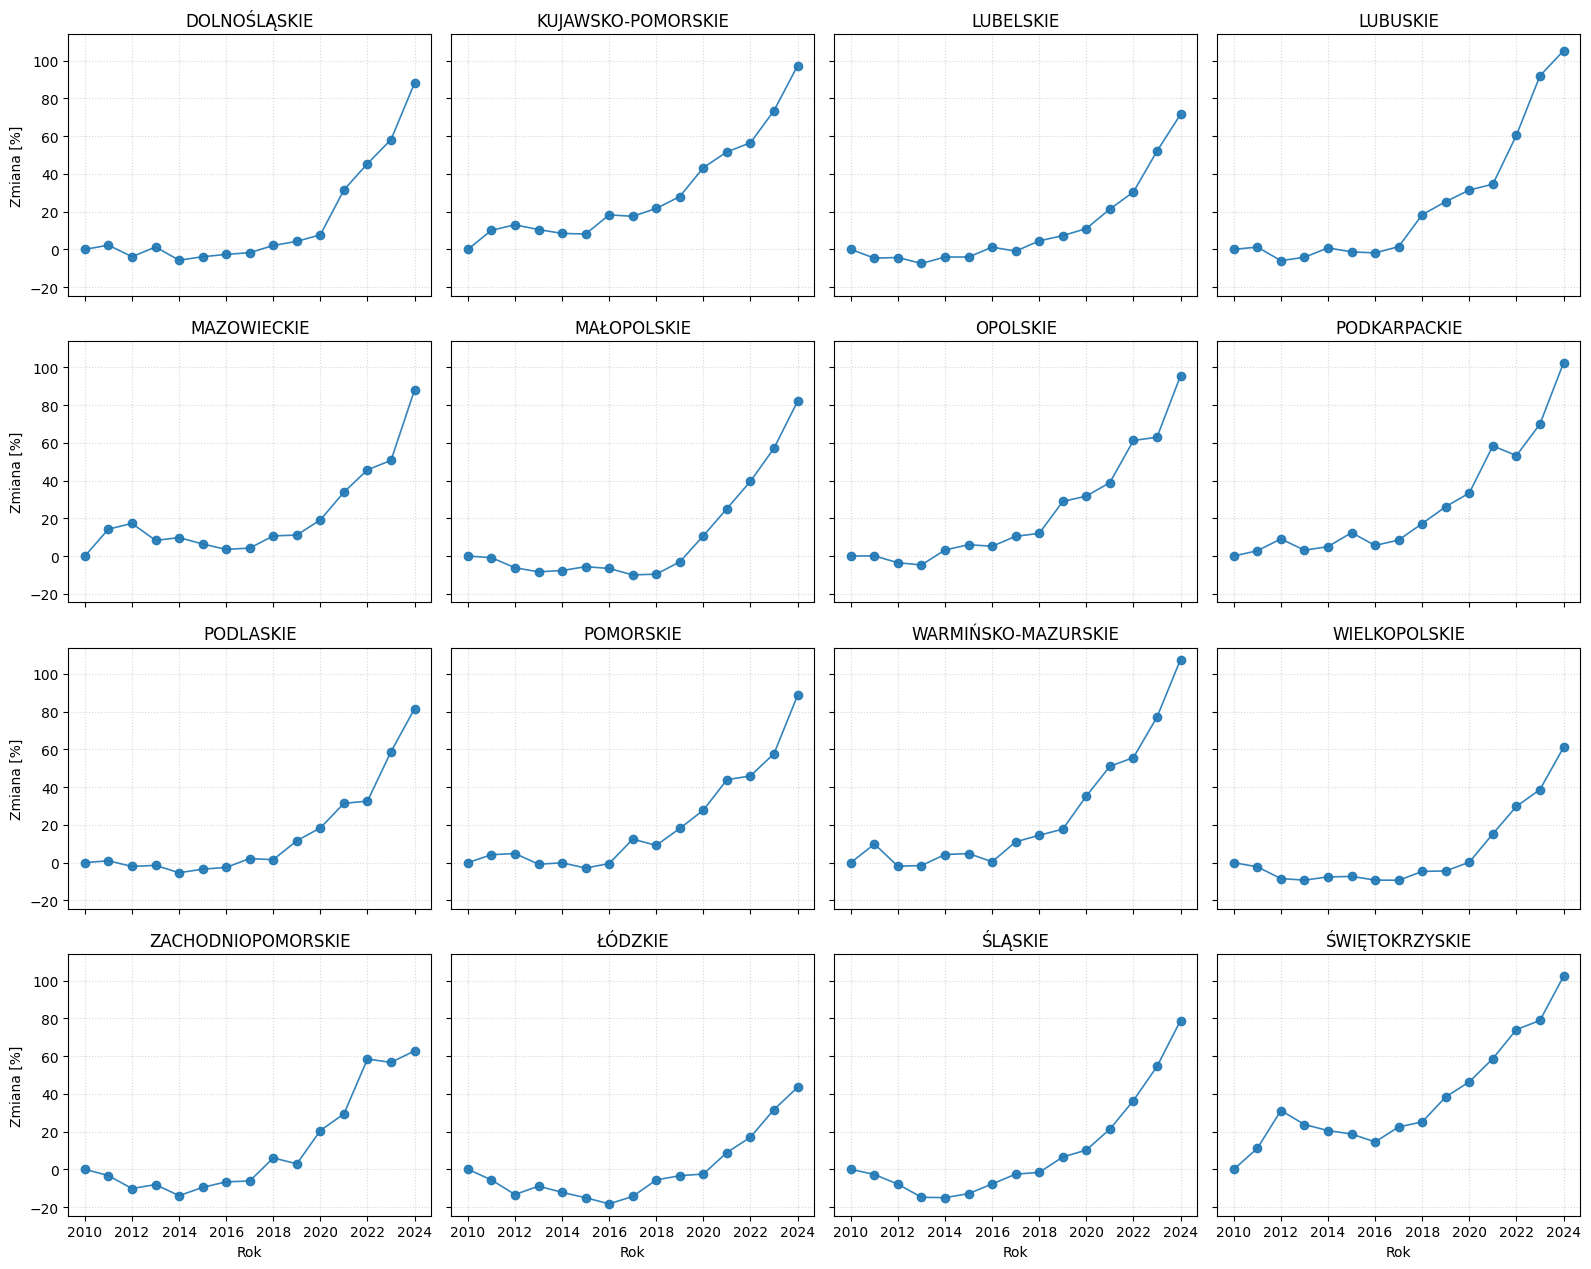

In [115]:
# Siatka wykresów: zmiana % względem pierwszego roku dla każdego województwa (rynek pierwotny)
import math
import matplotlib.pyplot as plt

voiv = dane.copy()
voiv["Rok"] = pd.to_numeric(voiv["Rok"], errors="coerce")
voiv["Wartosc"] = pd.to_numeric(voiv["Wartosc"], errors="coerce")
voiv = voiv.dropna(subset=["Rok", "Wartosc"])
voiv = voiv[voiv["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]
voiv = voiv[~voiv["Nazwa"].str.contains("POLSKA|powiat|gmina", case=False, na=False)]

pct_rows = []
for name, df in voiv.groupby("Nazwa"):
    df = df.sort_values("Rok")
    base = df.iloc[0]["Wartosc"]
    pct_rows.append(df.assign(pct_vs_first=(df["Wartosc"] / base - 1) * 100))
voiv_pct = pd.concat(pct_rows, ignore_index=True)

names = sorted(voiv_pct["Nazwa"].unique())
n = len(names)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, 3.2 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, name in enumerate(names):
    ax = axes[i]
    df = voiv_pct[voiv_pct["Nazwa"] == name]
    ax.plot(df["Rok"], df["pct_vs_first"], marker="o", linewidth=1.2, alpha=0.9)
    ax.set_title(name)
    ax.grid(True, linestyle=":", alpha=0.5)
    if i % cols == 0:
        ax.set_ylabel("Zmiana [%]")
    if i // cols == rows - 1:
        ax.set_xlabel("Rok")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [116]:
# Funkcja: pojedynczy wykres % dla wybranego województwa (rynek pierwotny)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def plot_voiv_percent(name, segment="rynek pierwotny"):
    target = name.strip().upper()
    df = dane.copy()
    df = df[df["Transakcje rynkowe"].str.contains(segment, case=False, na=False)]
    df["Rok"] = pd.to_numeric(df["Rok"], errors="coerce")
    df["Wartosc"] = pd.to_numeric(df["Wartosc"], errors="coerce")
    df = df.dropna(subset=["Rok", "Wartosc"])
    df["_nazwa"] = df["Nazwa"].str.strip().str.upper()
    df = df[df["_nazwa"] == target]
    df = df[~df["_nazwa"].str.contains("POLSKA|POWIAT|GMINA", case=False, na=False)]
    if df.empty:
        raise ValueError(f"Brak danych dla: {name}")
    df = df.sort_values("Rok")
    base = df.iloc[0]["Wartosc"]
    df = df.assign(pct_vs_first=(df["Wartosc"] / base - 1) * 100)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(df["Rok"], df["pct_vs_first"], marker="o", linewidth=1.5)
    ax.set_title(f"{df.iloc[0]['Nazwa']} – zmiana % względem pierwszego roku")
    ax.set_xlabel("Rok")
    ax.set_ylabel("Zmiana [%]")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.set_xticks(sorted(df["Rok"].unique()))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))
    plt.tight_layout()
    plt.show()


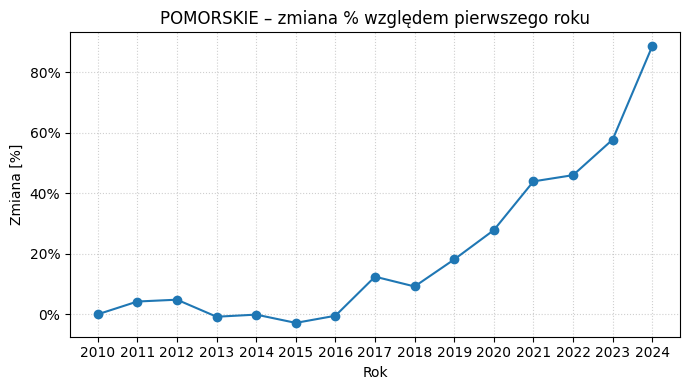

In [117]:
# Pomorskie – zmiana %
plot_voiv_percent("POMORSKIE")


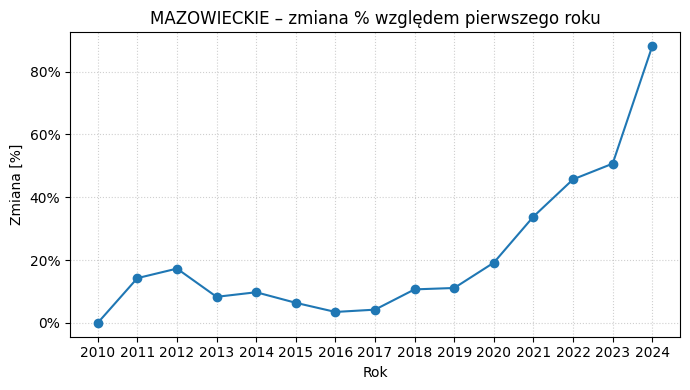

In [118]:
# Mazowieckie – zmiana %
plot_voiv_percent("MAZOWIECKIE")


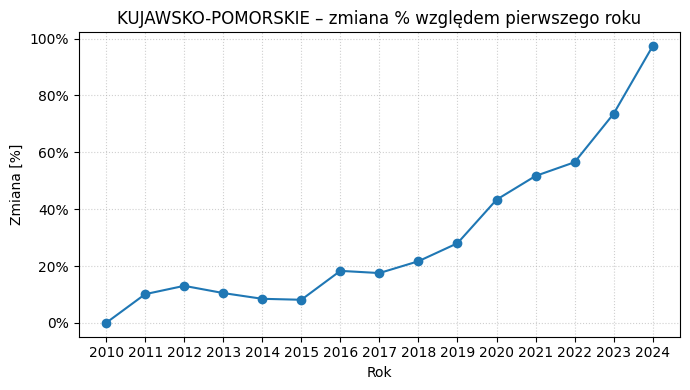

In [119]:
# Kujawsko-Pomorskie – zmiana %
plot_voiv_percent("KUJAWSKO-POMORSKIE")


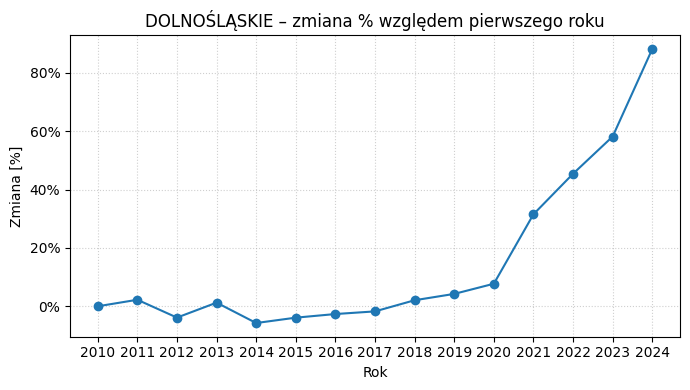

In [120]:
# Dolnośląskie – zmiana %
plot_voiv_percent("DOLNOŚLĄSKIE")


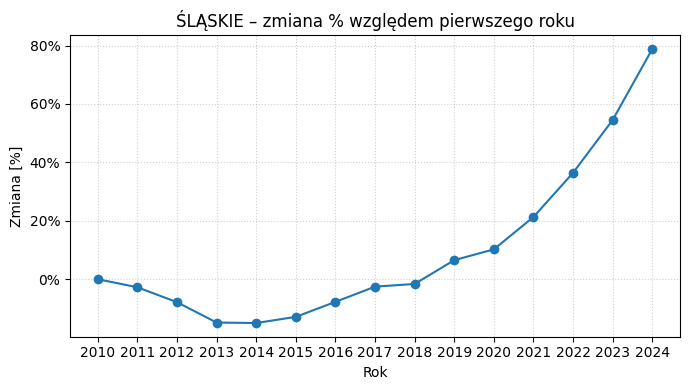

In [121]:
# Śląskie – zmiana %
plot_voiv_percent("ŚLĄSKIE")


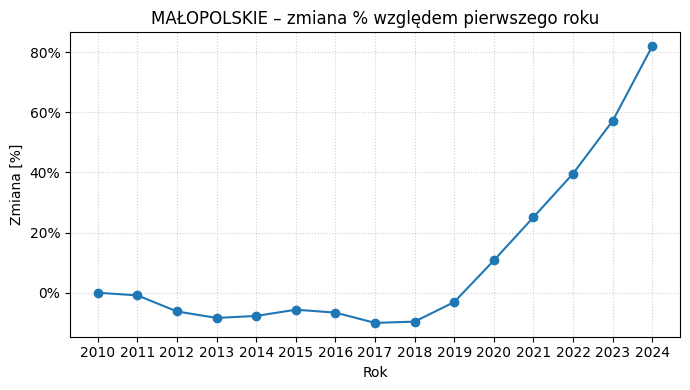

In [122]:
# Małopolskie – zmiana %
plot_voiv_percent("MAŁOPOLSKIE")


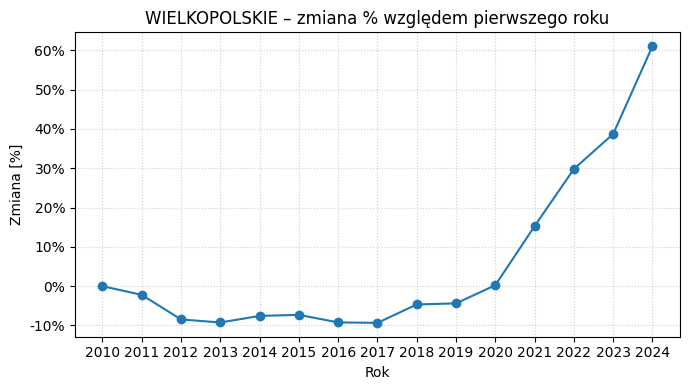

In [123]:
# Wielkopolskie – zmiana %
plot_voiv_percent("WIELKOPOLSKIE")


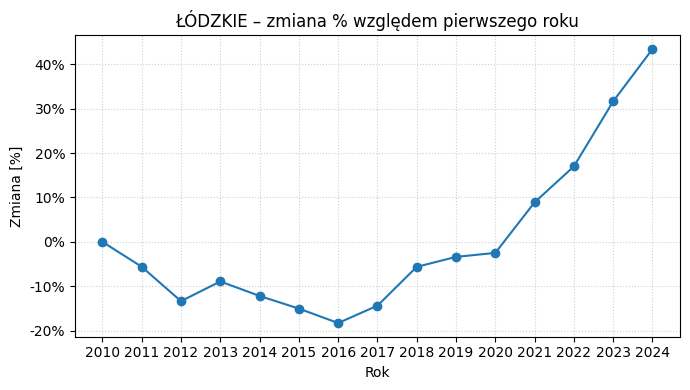

In [124]:
# Łódzkie – zmiana %
plot_voiv_percent("ŁÓDZKIE")


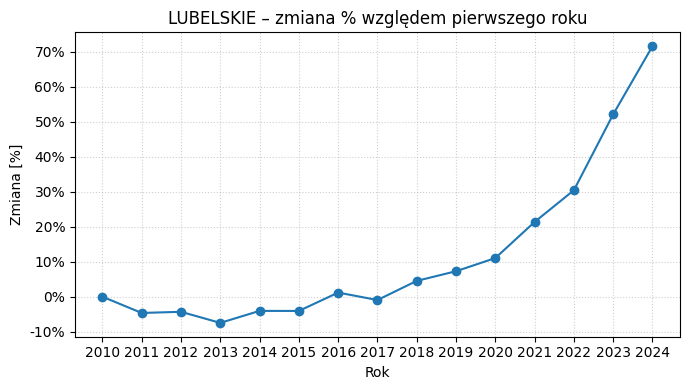

In [125]:
# Lubelskie – zmiana %
plot_voiv_percent("LUBELSKIE")


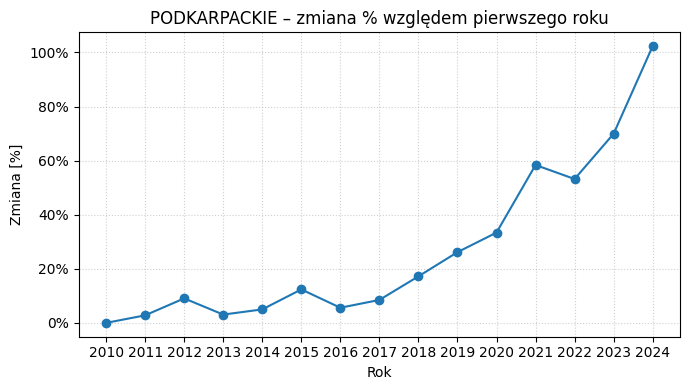

In [126]:
# Podkarpackie – zmiana %
plot_voiv_percent("PODKARPACKIE")


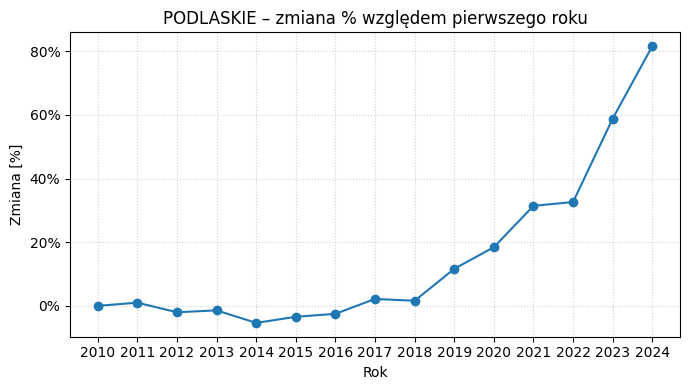

In [127]:
# Podlaskie – zmiana %
plot_voiv_percent("PODLASKIE")


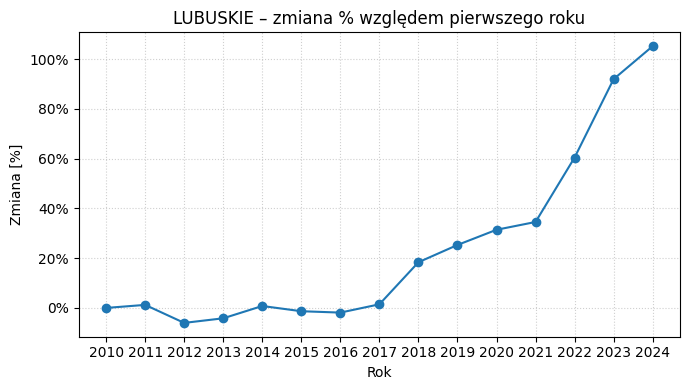

In [128]:
# Lubuskie – zmiana %
plot_voiv_percent("LUBUSKIE")


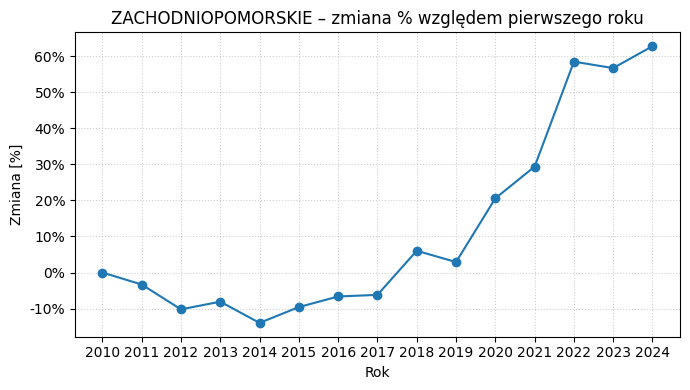

In [129]:
# Zachodniopomorskie – zmiana %
plot_voiv_percent("ZACHODNIOPOMORSKIE")


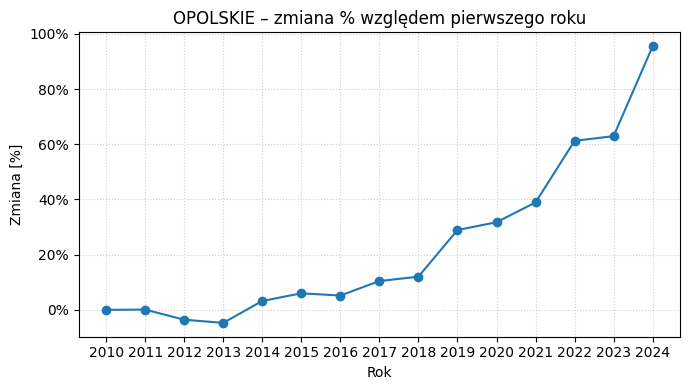

In [130]:
# Opolskie – zmiana %
plot_voiv_percent("OPOLSKIE")


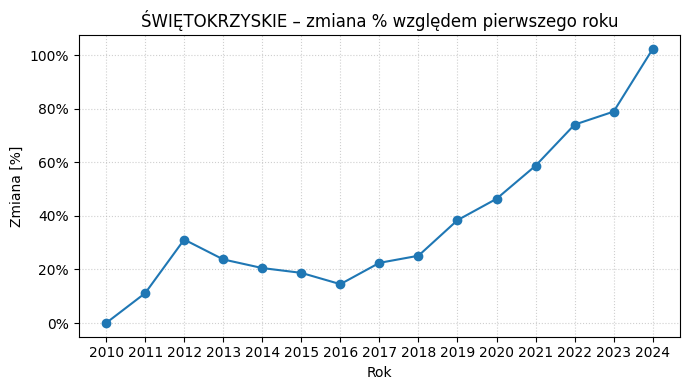

In [131]:
# Świętokrzyskie – zmiana %
plot_voiv_percent("ŚWIĘTOKRZYSKIE")


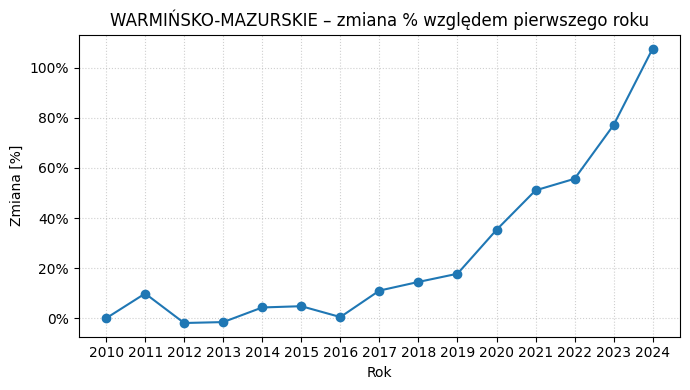

In [132]:
# Warmińsko-Mazurskie – zmiana %
plot_voiv_percent("WARMIŃSKO-MAZURSKIE")
